# Group Project 2, CSE 627
## Probabilistic Graphical Models(Undirected Graphs)
### Members: Chitraketu Pandey, Hemraj Ojha

In [44]:
#!pip install imageio
#!pip install fglib
from __future__ import division
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

import imageio

from fglib import graphs, nodes, inference, rv
import networkx as nx
from random import choice

import copy

import io
import base64
from IPython.display import HTML

np.random.seed(1234) # for generating the noise in image, in later section.


## Markov Random Fields
An undirected graphical model, has a set of nodes each of which corresponds to a variable or group of variables, as well as a set of links each of which connects a pair of nodes. The links are undirected.
The joint distribution for markov random fields are given by
$$ p(\mathbf{x}) = \frac{1}{Z} \prod_C \psi_C(\mathbf{x}_C).$$
where,C denotes maximal cliques,$\psi_C$ is $\textit{potential function}$ defined over cliques <br> and Z is called $\textit{partition function}$, is a normalization constant and is given by:
$$ Z = \sum_x\prod_C\psi_C(\mathbf{x}_C).$$

## Illustration: Image de-noising
This section of the notebook gives an example of how markov random fields can be used for noise removal from a binary image.
It is a very trivial way to do it however, it has a great significance in the field of image processing. 
The basic idea of image de-noising is that given a noisy binary image, (i.e, which have some pixels flipped), create a new image with least such noise.
### Intuition:
For the above task we will perform the following steps:
1. Take an image from MNIST dataset of any digit, 
2. Convert the image from grayscale to black and white, 
3. Randomly flip some of the pixels of the image from 1 to -1 and vice versa(to generate a noisy image),
4. Try to increase the joint probability of the image using a simple algorithm called "Iterated Conditional Modes", (mentioned in the book PRML section 8.3.3)

### Obtaining sample images from MNIST dataset.
The sample images are taken from one of the kaggle dataset provided here[https://www.kaggle.com/scolianni/mnistasjpg/version/1]


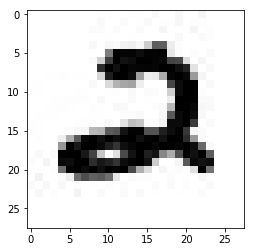

In [3]:
#fetching an image
# the images for 2,3,4,5,7,9 are already downloaded and provided in the same folder level.
img_gray = imageio.imread('img_2.jpg')
plt.imshow(img_gray,cmap='Greys')

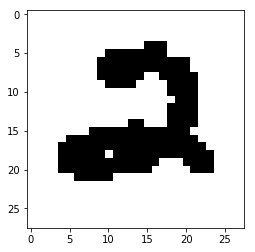

In [4]:
#converting the picture to black and white
img_gray_arr = np.asarray(img_gray,int)
img_mean = np.mean(img_gray_arr)
img_arr = np.copy(img_gray_arr)
img_arr[img_gray_arr<img_mean] = -1
img_arr[img_gray_arr>= img_mean] = 1
plt.imshow(img_arr,cmap='Greys')

In [5]:
#Sanity check if they have only 1 and -1 or not
img_arr

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
         1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
         1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  

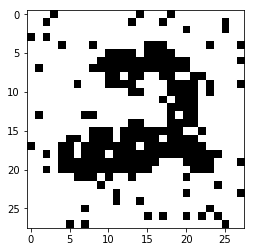

In [6]:
def make_noisy_image(lena_arr,per=0.1):
    total_pixels = lena_arr.shape[0]*lena_arr.shape[1]
    num_flips = int(per*total_pixels)
    px_to_flip = np.random.randint(low=0, high=total_pixels, size=num_flips)
    
    for i in px_to_flip:
        row_num = int(math.floor(i/lena_arr.shape[0]))
        col_num = i%lena_arr.shape[0]
        if lena_arr[row_num,col_num] == 1:
            lena_arr[row_num,col_num] =-1
        else:
            lena_arr[row_num, col_num]=1
    
noisy_img_arr = np.copy(img_arr) #important to deep copy the original array
make_noisy_image(noisy_img_arr)
plt.imshow(noisy_img_arr,cmap='Greys')

In [7]:
def percent_pixel_flipped(noisy_arr,denoised_arr):
    num_flipped = 0
    total_px = noisy_arr.shape[0]*noisy_arr.shape[1]
    for i in range(noisy_arr.shape[0]):
        for j in range(noisy_arr.shape[1]):
            if noisy_arr[i,j]!= denoised_arr[i,j]:
                num_flipped+=1
   
    percent_change = num_flipped*100./total_px
    return percent_change

print( percent_pixel_flipped(noisy_img_arr, img_arr))

8.928571428571429


### The Ising Model

Let the observed image is described by array of pixels $y_i \epsilon \{-1,+1\}$. And let the unknown noise-free image be described by pixels $x_i \epsilon \{-1,+1\}$, where i runs over all the pixels. <br />
Since, the noise level is small, there is a prior belief that there will be a strong correlation between $x_i$ and $y_i$ .
And also the neigbouring pixels $x_i$ and $x_j$ are strongly correlated.<br /><br />
This information can be represented using Markov Random Field whose undirected graph is shown in the image given below.


The complete energy function to model the above MRF can be expressed as:
$$ E(\mathbf{x,y}) = h\sum_{i}x_i - \beta\sum_{\{i,j\}}x_ix_j - \eta\sum_{i}x_iy_i $$,
where, the last term captures the information that the pixel of noisy image and unknown noise-free image are correlated,<br />
the second term captures the information that the neigbour pixels of noise-free image are strongly correlated <br />
and the first term showns the effect of biasing the model towards pixel values that have one particular sign in preference to other.
<br>
And the joint probability distribution over $\mathbf{x}$ and $\mathbf{y}$ given by:
$$ p(\mathbf{x,y}) = \frac{1}{Z} exp\{ - E (\mathbf{x,y})\}. $$

This model is an example of $\textit{Ising model}$, which has been widely studied in statistical physics.

<img src="Ising_model.png"/>

In [8]:
def check_limit(value, limit):
    if value<0:
        value=limit-1
    if value==limit:
        value=0
    return value

def add_energy_contribution(visible_arr,hidden_arr, x_val,y_val, const_list):
    h_val = const_list[0]
    beta = const_list[1]
    eta = const_list[2]
    total_pixels = hidden_arr.shape[0]*hidden_arr.shape[1]
    energy = h_val*hidden_arr[x_val,y_val]
    energy += -eta*hidden_arr[x_val,y_val]*visible_arr[x_val,y_val]
    x_neighbor = [-1,1]
    y_neighbor = [-1,1]
    for i in x_neighbor:
        for j in y_neighbor:
            x_n = check_limit(x_val +i,hidden_arr.shape[0])
            y_n = check_limit(y_val +j, hidden_arr.shape[1])
            
            energy += -beta*hidden_arr[x_val,y_val]*hidden_arr[x_n,y_n]
    energy = energy/total_pixels
    return energy

def calculate_total_energy(visible_arr,hidden_arr,const_list):
    energy = 0.
    for i in range(visible_arr.shape[0]):
        for j in range(visible_arr.shape[1]):
            energy += add_energy_contribution(visible_arr,hidden_arr,i,j,const_list)
    return energy

#this list is [h, beta,eta]
const_list = [0,.1,.02]
hidden_image = np.copy(noisy_img_arr)
total_energy= calculate_total_energy(noisy_img_arr, hidden_image, const_list)

print (total_energy)

-0.22918367346938576


### Iterative Conditional Mode
It is a simple application of coordinate-wise gradient ascent algorithm. <br>
The pseudocode is given as follows:
1. Initialize the pixels of unknown noise-free image with the pixels of noisy image, $x_i = y_i$. 
2. Take one node at a time and evaluate total energy for two possible states $x_j = +1 $ and $x_j = -1$, keeping all node fixed and set $x_j$ to whichever node gives lowest energy. T
3. Repeat step 2 until the energy converges. 

In [9]:
def icm_single_pixel(visible_arr, hidden_arr, px_x, px_y, total_energy, const_list):
    current_energy = add_energy_contribution(visible_arr, hidden_arr,px_x,px_y, const_list)
    other_energy = total_energy - current_energy
    #flip the pixel
    new_hidden_arr = np.copy(hidden_arr)
    if hidden_arr[px_x,px_y]==1:
        new_hidden_arr[px_x,px_y]=-1
    else:
        new_hidden_arr[px_x,px_y] = 1
    flipped_energy = add_energy_contribution(visible_arr, new_hidden_arr,px_x,px_y, const_list)
    #print current_energy, flipped_energy
    if flipped_energy < current_energy:
        should_flip = True
        total_energy = other_energy + flipped_energy
        hidden_arr = new_hidden_arr
        #print percent_pixel_flipped(hidden_arr, visible_arr)
    else:
        should_flip = False
    
    return (hidden_arr,should_flip,total_energy)
    #return (should_flip, hidden_arr, total_energy)

#main icm simulation
hidden_image = np.copy(noisy_img_arr)
energy_this_round = total_energy
print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

for sim_round in range(5):
    for i in range(hidden_image.shape[0]):
        for j in range(hidden_image.shape[1]):
            hidden_image,should_flip,total_energy = icm_single_pixel(noisy_img_arr,hidden_image,i,j, total_energy,const_list)
            
        #print percent_pixel_flipped(hidden_image, lena_arr)
    if (total_energy - energy_this_round) == 0:
        print( "Algorithm converged")
        break
    energy_this_round = total_energy
    print ("Total Energy:",total_energy)
    print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))


% Pixels flipped: 8.928571428571429
Total Energy: -0.28132653061224255
% Pixels flipped: 3.316326530612245
Total Energy: -0.2838265306122427
% Pixels flipped: 2.6785714285714284
Algorithm converged


The obtained denoised image


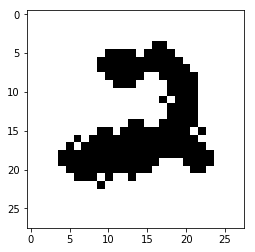

In [10]:
plt.imshow(hidden_image,cmap='Greys')
print('The obtained denoised image')

## Todo:
Try to run the same algorithm on image 3 ('img_3.jpg') with fliping 20 % of the pixels.

## Inference in Graphical Models
### Background:
**Factor Graphs**
Both directed and undirected graphs allow a global function of several variables to be expressed as a product of factors over subsets of those variables. Factor graphs make this decomposition explicit by introducing additional nodes for the factors themselves in addition to the nodes representing the variables. The joint probability distribution over a set of variables in the form of product of factors is given as:
$$ p(\mathbf{x}) = \prod_s f_s(\mathbf{x_s}) $$
where, $\mathbf{x_s}$ denotes a subset of the variables.
<br>
Below is given an example from book PRML showing factorization of directed graph and their corresponding variations of factor graph.

<img src="factor_graph_example.png" />

In [14]:
#first example
#!/usr/bin/env python

"""A simple example of sum-product, max-product and max-sum algorithm
This is a simple example of the sum-product algorithm on a factor graph on example tree-structured
graph shown in above picture.

      /--\      +----+      /--\      +----+      /--\
     | x1 |-----| fa |-----| x2 |-----| fb |-----| x3 |
      \--/      +----+      \--/      +----+      \--/
                             |
                           +----+
                           | fc |
                           +----+
                             |
                            /--\
                           | x4 |
                            \--/
The following joint distributions are used for the factor nodes.
     fa   | x2=0 x2=1     fb   | x3=0 x3=1     fc   | x4=0 x4=1
     ----------------     ----------------     ----------------
     x1=0 | 3  4          x2=0 | 3  4          x2=0 | 7  8
     x1=1 | 3  0          x2=1 | 5  1          x2=1 | 3  9
"""



# Create factor graph
fg = graphs.FactorGraph()

# Create variable nodes
x1 = nodes.VNode("x1", rv.Discrete)
x2 = nodes.VNode("x2", rv.Discrete)
x3 = nodes.VNode("x3", rv.Discrete)
x4 = nodes.VNode("x4", rv.Discrete)

# Create factor nodes (with joint distributions)
dist_fa = [[3, 4],
           [3, 9]]
fa = nodes.FNode("fa", rv.Discrete(dist_fa, x1, x2))

dist_fb = [[3, 4],
           [5, 1]]
fb = nodes.FNode("fb", rv.Discrete(dist_fb, x2, x3))

dist_fc = [[7, 8],
           [3, 9]]
fc = nodes.FNode("fc", rv.Discrete(dist_fc, x2, x4))

# Add nodes to factor graph
fg.set_nodes([x1, x2, x3, x4])
fg.set_nodes([fa, fb, fc])

# Add edges to factor graph
fg.set_edge(x1, fa)
fg.set_edge(fa, x2)
fg.set_edge(x2, fb)
fg.set_edge(fb, x3)
fg.set_edge(x2, fc)
fg.set_edge(fc, x4)

# providing the position for each nodes as a dictionary which will be used to visualize the graph in later section
pos = {x1:(-7.5,7.5),fa:(-4,7.5),x2:(0,7.5),fb:(4,7.5),x3:(7.5,7.5), fc:(0,3), x4:(0,0)}


In [63]:
# function to visualize a graph using scatter function
# and plot function of matplotlib
def drawgraphWithMessage(G,pos=None, chosen_node=None, 
                         flow_direction=None, backward=False, messages=None,
                         messages_node=None):
    """This function is used to visualize a factor graph
    Parameters:
    G:              a graph (instance of fglib graph a subclass of networkx graph) 
    
    pos:            a dictionary having key= (node in graph) and 
                    value = (a tuple(x,y) :location in co-ordinate axes i.e, x and y)
                    
    chosen_node:    a node which is chosen as root to run forward and backward message passing
    
    flow_direction: a list of tuples in the format (u,v) where the direction is u -> v
    
    backward:       a boolean to show the reverse direction based on flow_direction edges
    
    messages:       a list of tuples in the format (u,v,msg) where direction is u -> v and 
                    have message 'msg' to be annotated on that edge
    
    messages_node:  a list of tuples in the format (u,msg) where u is the location of node and have 
                    message 'msg' to be annotated on that node.
                    
    Returns: None 
    Draws a graph inside the function.
    """
    
    #if position not provided get the positions of nodes from networkx spring_layout 
    if pos == None:
        pos = nx.spring_layout(G,scale=10)
    
    if chosen_node is None:  # pick random node
        chosen_node = choice(G.get_vnodes())

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    #getting the variable and factor nodes
    v_nodes = G.get_vnodes();
    f_nodes = G.get_fnodes();
    
    #drawing the message flow direction
    if flow_direction != None:
        for (v,u) in flow_direction:
            
            # swapping u,v if the direction is backward
            if backward == True:
                u,v = v,u
            
            x1,y1 = pos[u]
            x2,y2 = pos[v]
            
            #drawing direction from 1/3rd of line_segment to 2/3rd of line_segment using annotate function
            ax.annotate('',xy=((1*x1+3*x2)/4,(1*y1+3*y2)/4),xytext=((3*x1+1*x2)/4,(3*y1+1*y2)/4),
                        arrowprops=dict(facecolor='blue', edgecolor='red'))
            
    #drawing the messages over the node
    if messages_node != None:
        for (u,msg) in messages_node:
            x1,y1 = pos[u]
            #annotating the midpoint of the edge with the message provided as a list
            ax.annotate(msg,xy=(x1,y1),
                        xytext=(x1-1,y1+1),
                        arrowprops=dict(arrowstyle="->"))

    #drawing the messages over the edges
    if messages != None:
        for(u,v,msg) in messages:
            x1,y1 = pos[u]
            x2,y2 = pos[v]
            
            #annotating the midpoint of the edge with the message provided as a list
            ax.annotate(msg,xy=((x1+x2)/2,(y1+y2)/2),
                        xytext=((x1+x2)/2-1,(y1+y2)/2+1),
                        arrowprops=dict(arrowstyle="->"))
            
    
    #drawing the edges of the graph
    for node in G.adjacency():
        vertices = []
        for edge in node[1]:
            vertices.append(tuple(pos[node[0]]))
            vertices.append(tuple(pos[edge]))
            x,y = zip(*vertices)
            plt.plot(x,y,'r-',linewidth=2)
            
    #drawing the variable nodes of the graph which are of shape 'circle'
    for node in v_nodes:
        ax.annotate(node,xy=(pos[node][0],pos[node][1]+.45))
        plt.scatter(pos[node][0],pos[node][1],marker='o',s=800,facecolors='r',edgecolors='r')
        
    #drawing the factor nodes of the graph which are of shape 'square'
    for node in f_nodes:
        ax.annotate(node,xy=(pos[node][0],pos[node][1]+.45))
        plt.scatter(pos[node][0],pos[node][1],marker='s',s=500,facecolors='r')
    
    #marking the root node with a bigger circle
    plt.scatter(pos[chosen_node][0],pos[chosen_node][1],s=1500,facecolors='none',edgecolors='r')
    
    plt.show()
    

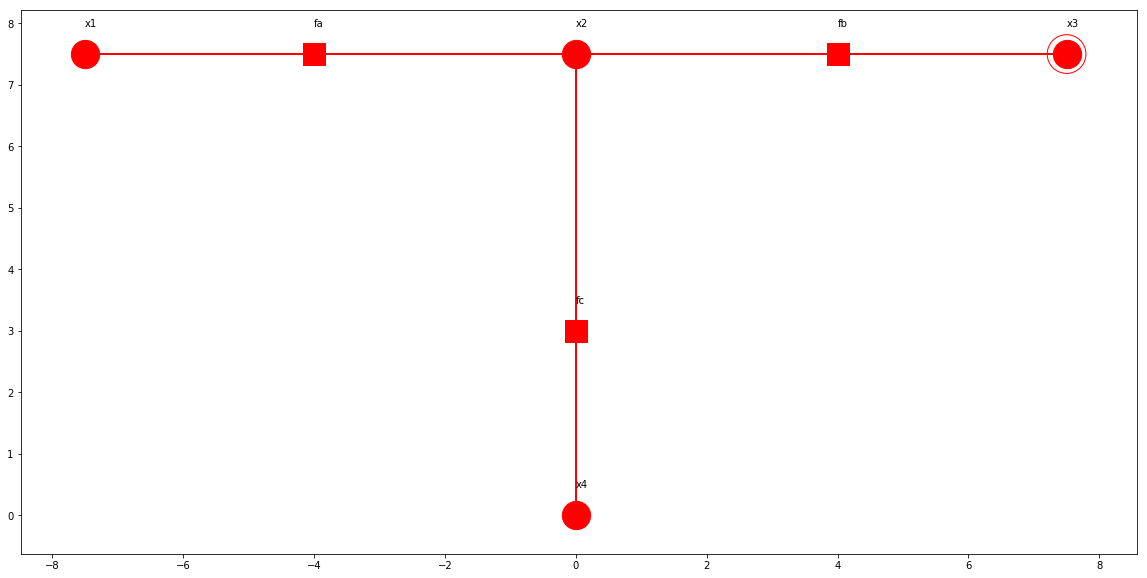

In [64]:
# drawing the example graph where the x3 is chosen as root node.
drawgraphWithMessage(fg,chosen_node=x3,pos=pos)

### Sum-product algorithm
Sum-product algorithm is an algorithm used to calculate the marginal probability over variable nodes. It provides exact-inference for tree-structured graphs and can be extended to another algorithm called loopy-belief propagation to give approximate inference to general graphs(consisting loops.)
Below we will see an illustration of sum-product algorithm over tree-structured graph taken from PRML book which is as shown in the figure given below: 

<img src="tree_graph.png"  />

the forward message pass


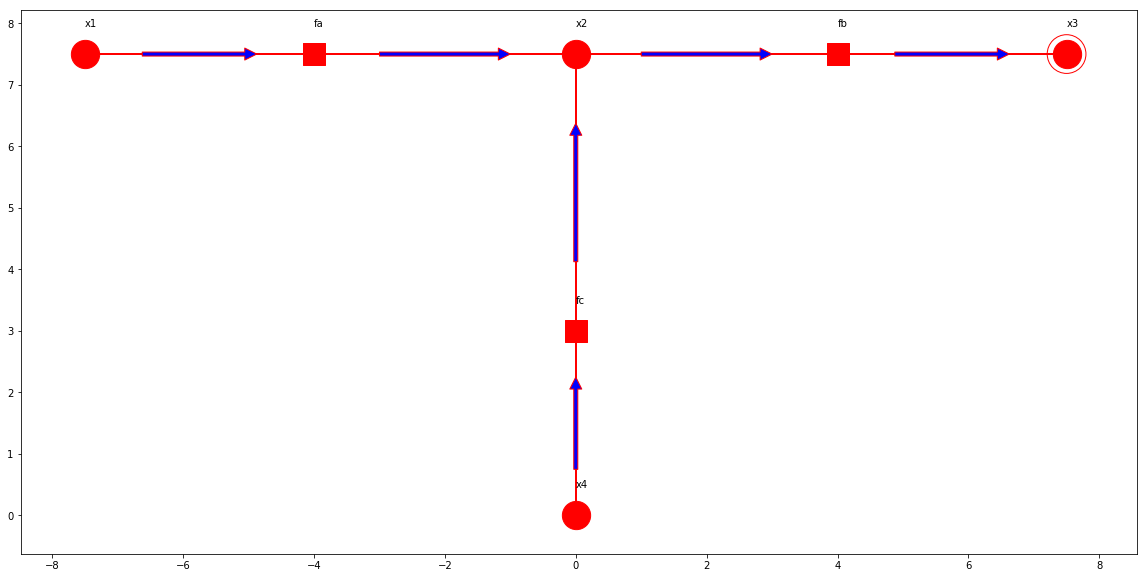

the backward message pass 


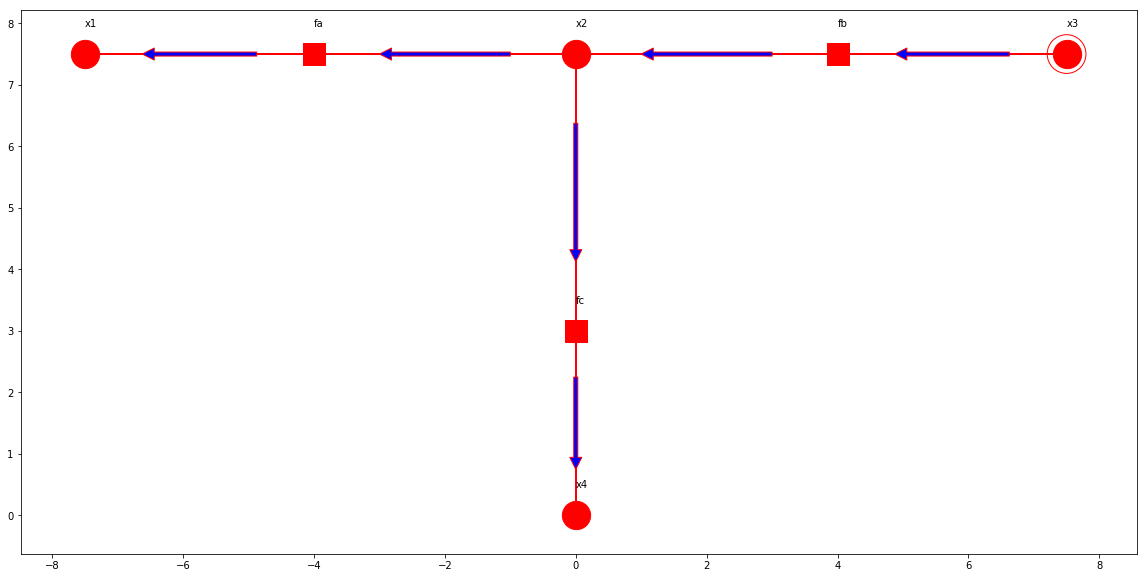

In [65]:
#drawing the forward and backward message flow
#this can be found by running Depth first search from node x3.
#dfs function is used from networkx graph to get the edges
dfs = list(nx.dfs_edges(fg,x3))
print('the forward message pass')
drawgraphWithMessage(fg, pos=pos, chosen_node=x3, flow_direction=dfs)
print('the backward message pass ')
drawgraphWithMessage(fg, pos=pos, chosen_node=x3, flow_direction=dfs, backward=True)

### The sum-product algorithm

In [40]:
# a method taken from fglib python library and the function modified to show intermediate steps as we
# go through the algorithm

def belief_propagation(graph, query_node=None, pos=None):
    """Belief propagation.
    Perform exact inference on tree structured graphs.
    
    
    Parameters:
    graph:      instance of fglib graph ( a subclass of networkx graph) 
    query_node: the node chosen to run the algorithm
    pos:        a dictionary having key= (node in graph) and 
                value = (a tuple(x,y) :location in co-ordinate axes i.e, x and y)
    
    Return the belief of query_node.
    """

    if query_node is None:  # pick random node
        query_node = choice(graph.get_vnodes())

    # Depth First Search to determine edges
    dfs = nx.dfs_edges(graph, query_node)

    # Convert tuple to reversed list
    backward_path = list(dfs)
    forward_path = reversed(backward_path)
    
    print('the chosen node')
    print(query_node)
    print()
    print('forward')
    # Messages in forward phase
    if pos == None:
        pos = nx.spring_layout(graph,scale=10)
    
    messages = []
    for (v, u) in forward_path:  # Edge direction: u -> v
        print(u,v)
        msg = u.spa(v)
        print(msg) 
        messages.append((u,v,copy.deepcopy(msg)))
        print()
        graph[u][v]['object'].set_message(u, v, msg)
        drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, flow_direction=backward_path,messages=messages)
        

    print('backward')
    # Messages in backward phase
    messages = []
    for (u, v) in backward_path:  # Edge direction: u -> v
        msg = u.spa(v)
        print(u,v)
        print(msg)
        messages.append((u,v,copy.deepcopy(msg)))
        print()
        graph[u][v]['object'].set_message(u, v, msg)
        drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, 
                             flow_direction=backward_path,backward=True,messages=messages)

    # Return marginal distribution
    return query_node.belief()


the chosen node
x3

forward
x4 fc
[[1.]
 [1.]]



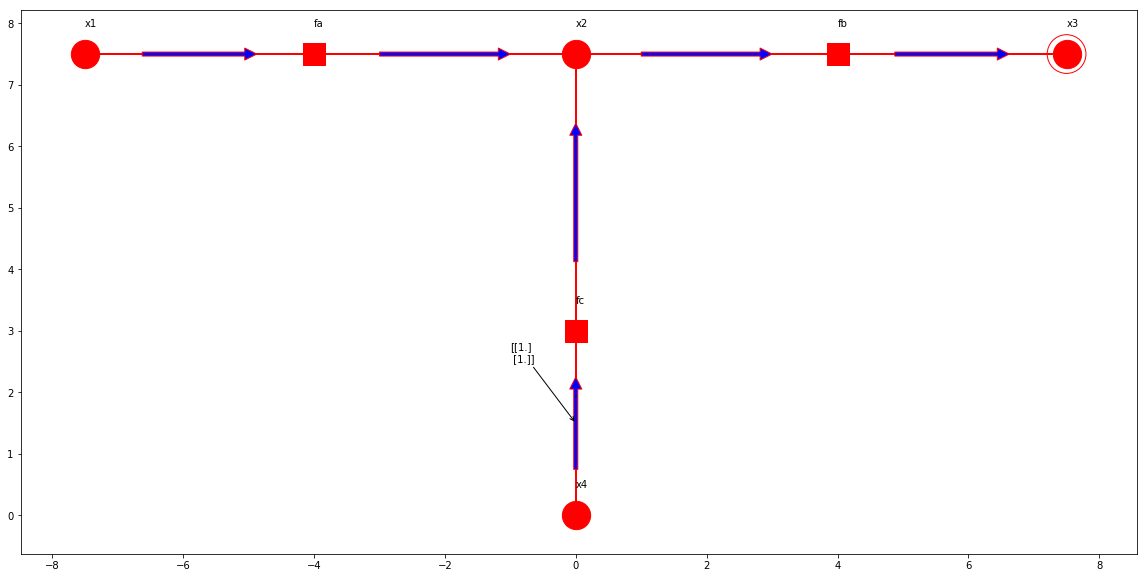

fc x2
[15. 12.]



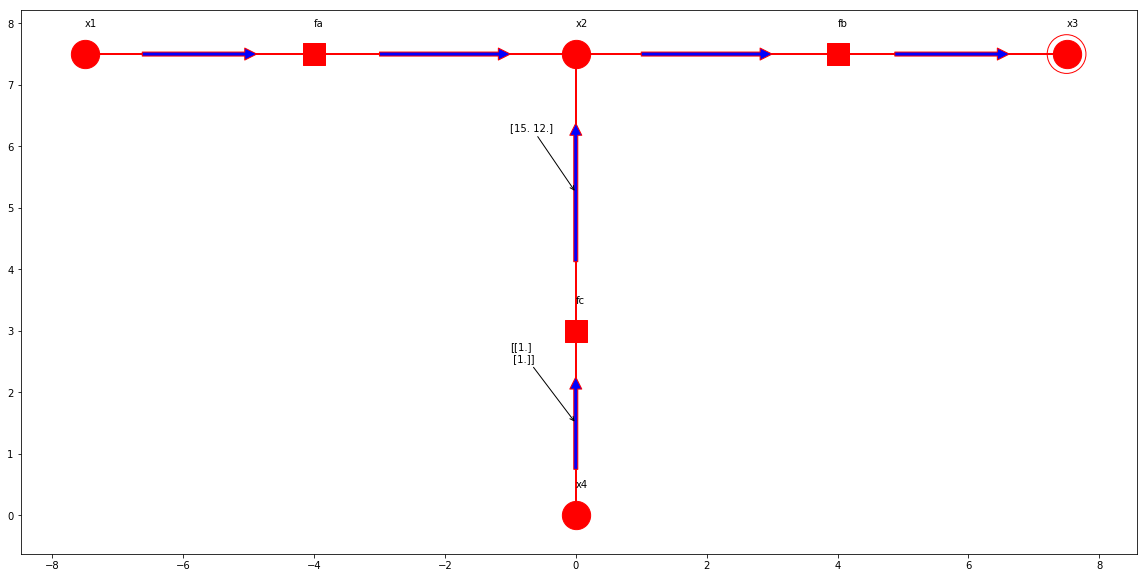

x1 fa
[[1. 1.]]



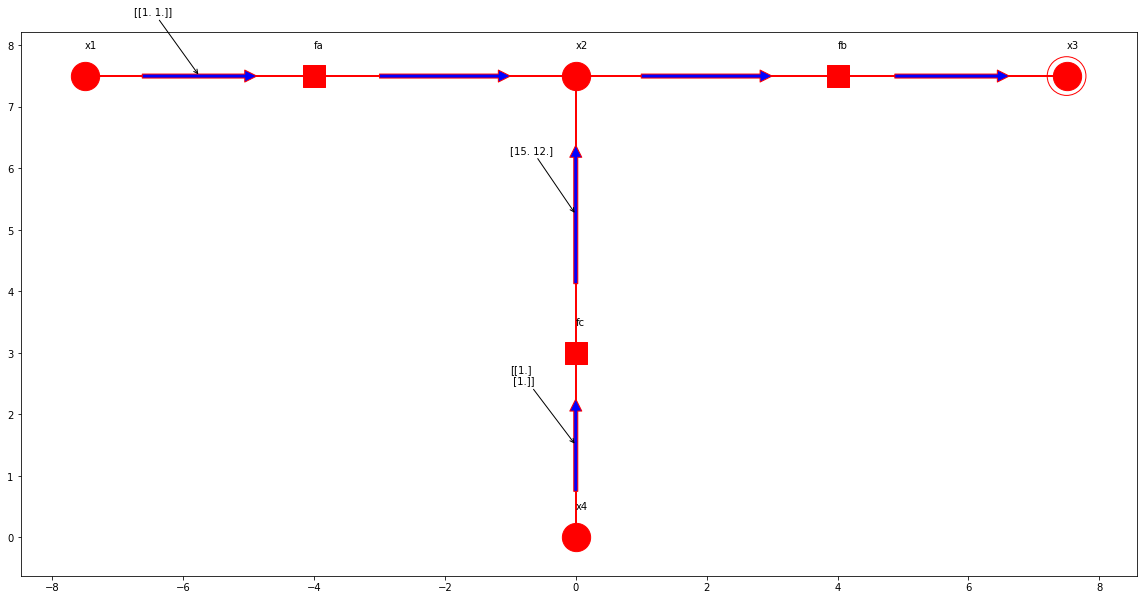

fa x2
[ 6. 13.]



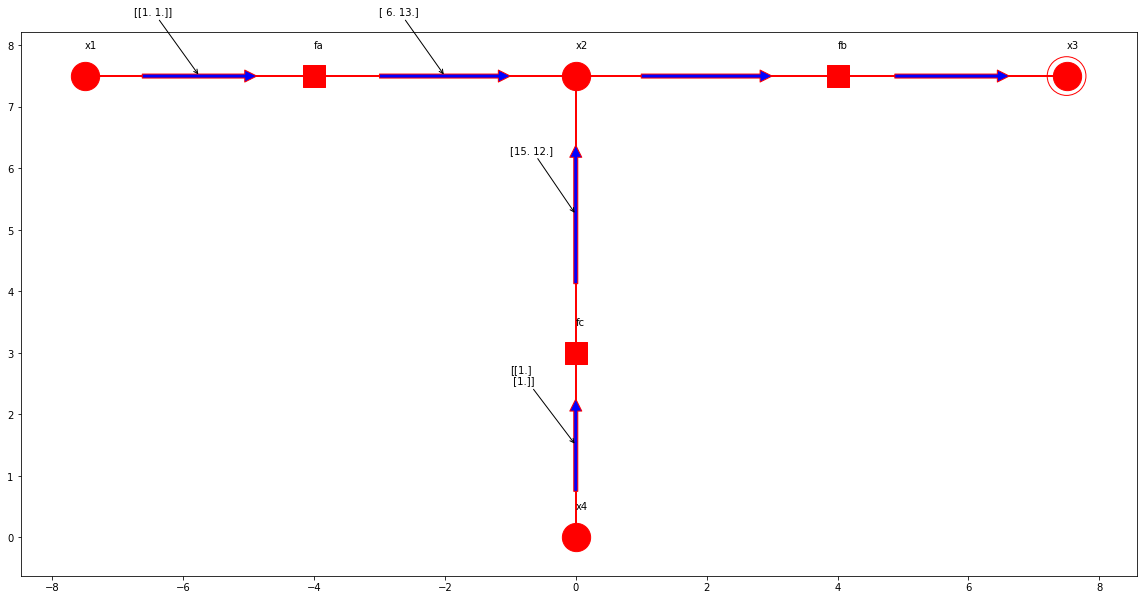

x2 fb
[ 90. 156.]



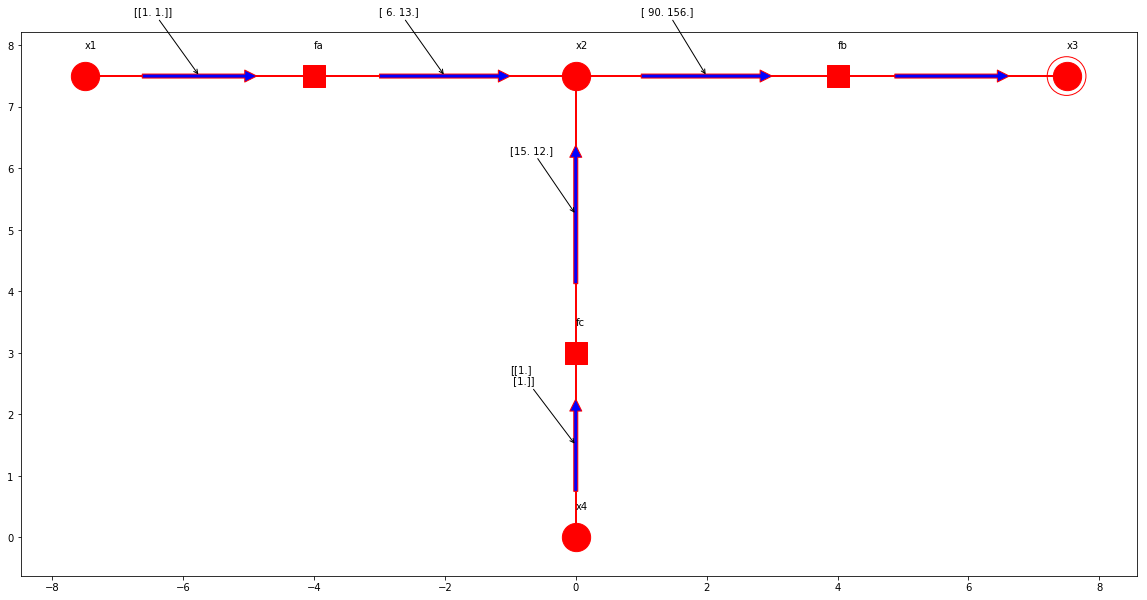

fb x3
[1050.  516.]



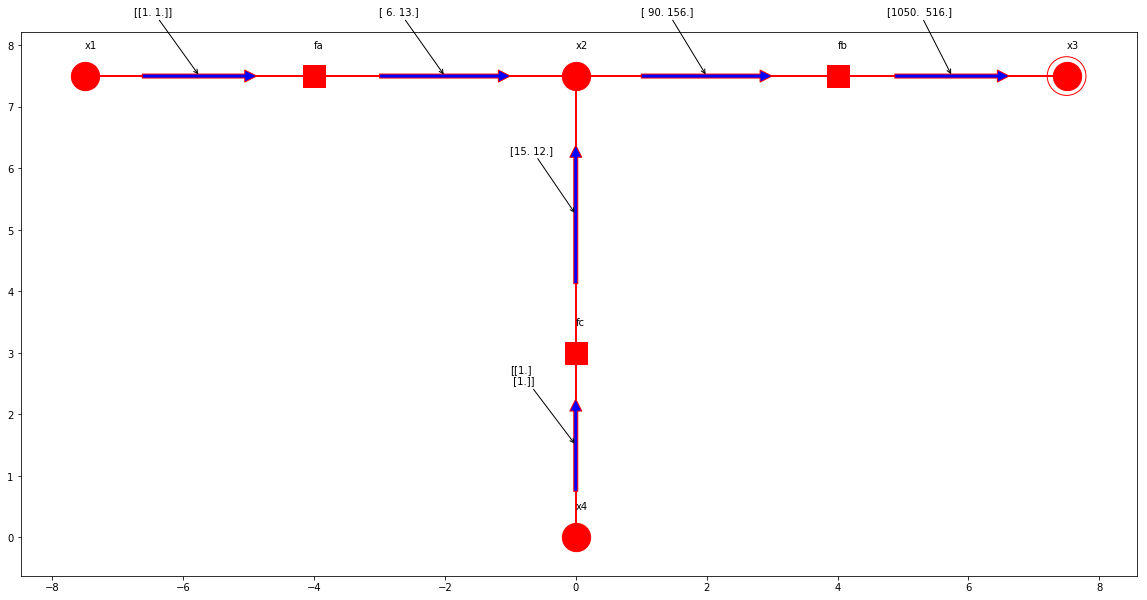

backward
x3 fb
[[1.]
 [1.]]



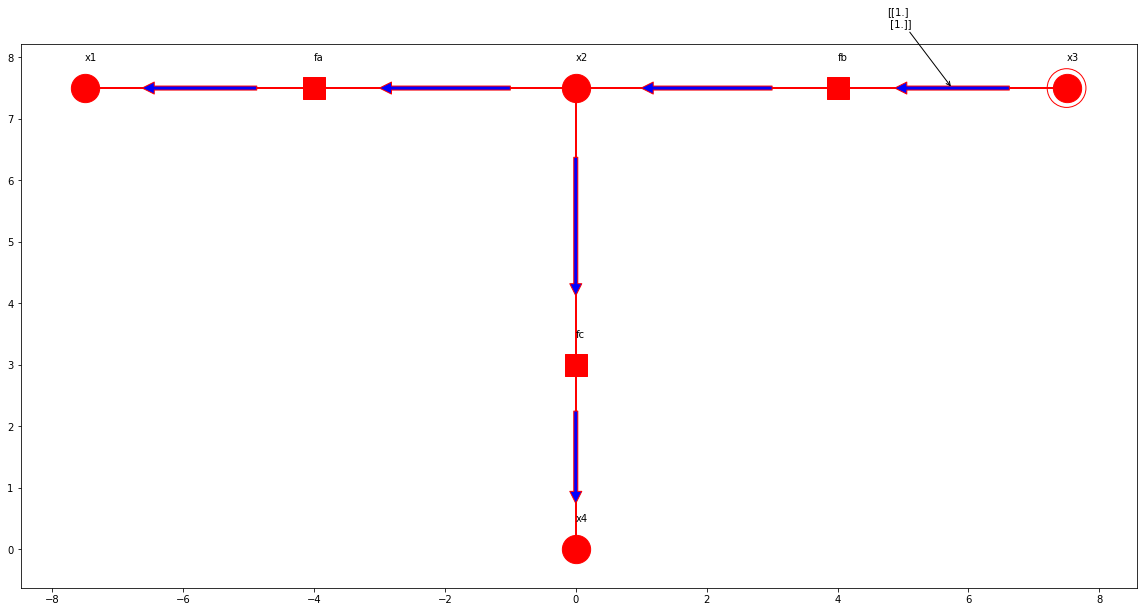

fb x2
[7. 6.]



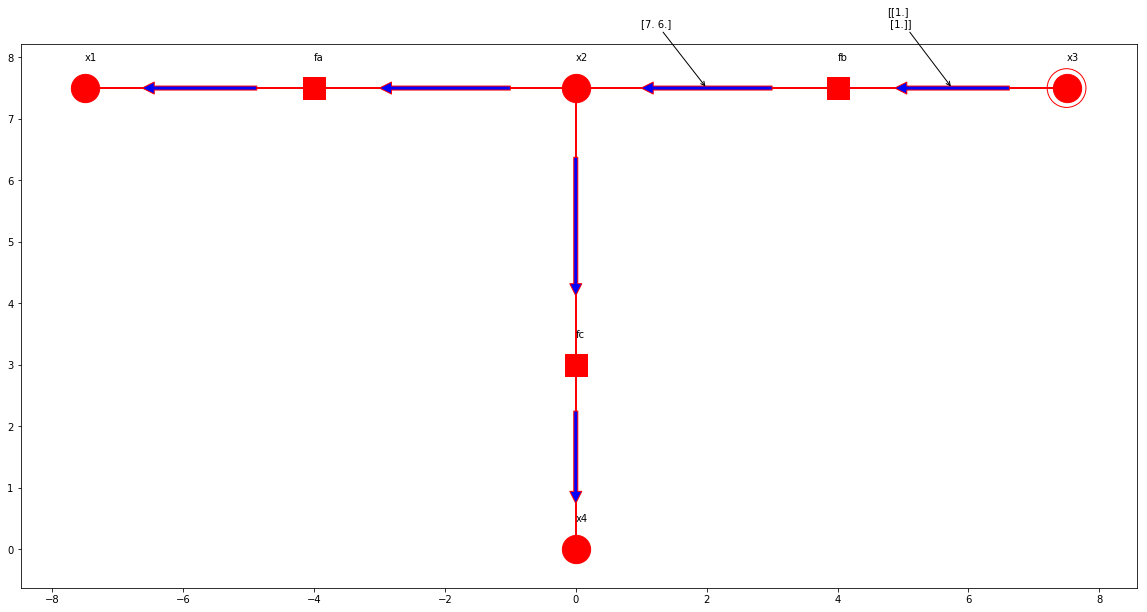

x2 fa
[105.  72.]



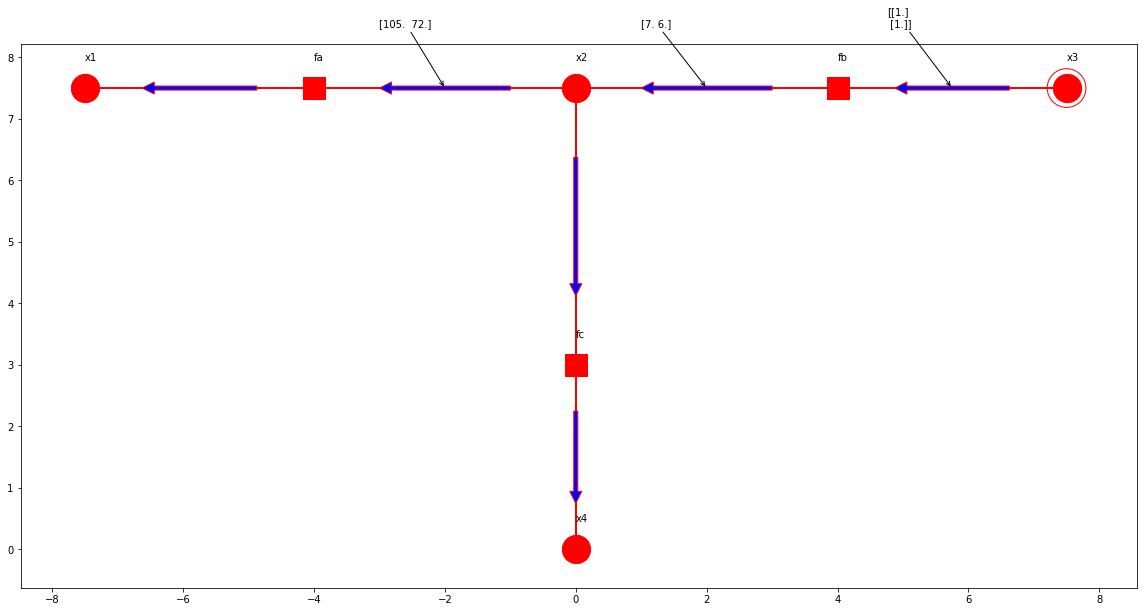

fa x1
[603. 963.]



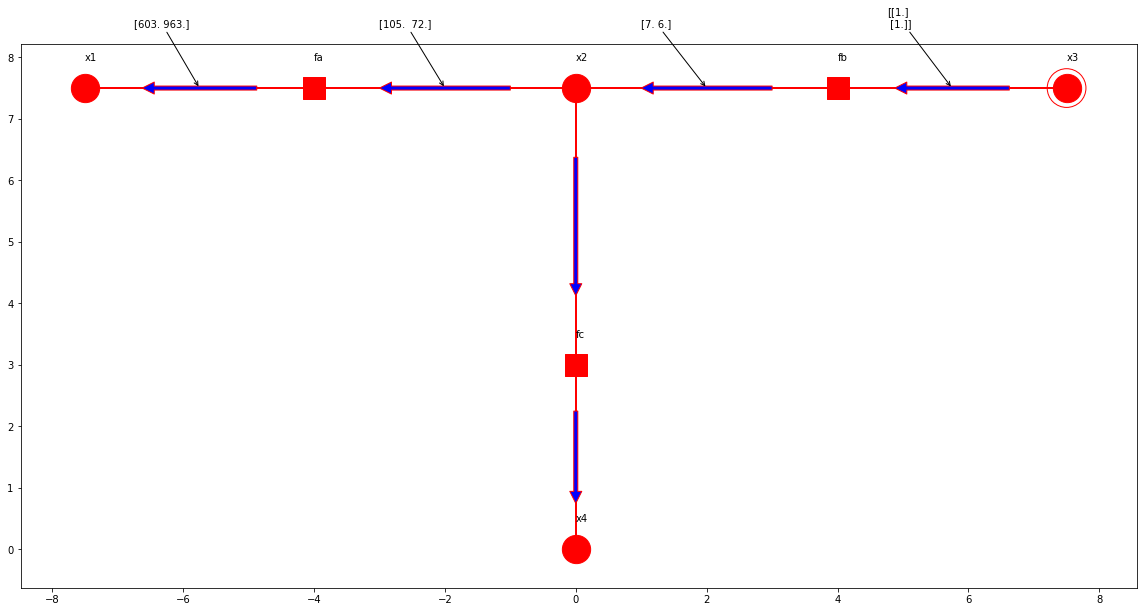

x2 fc
[42. 78.]



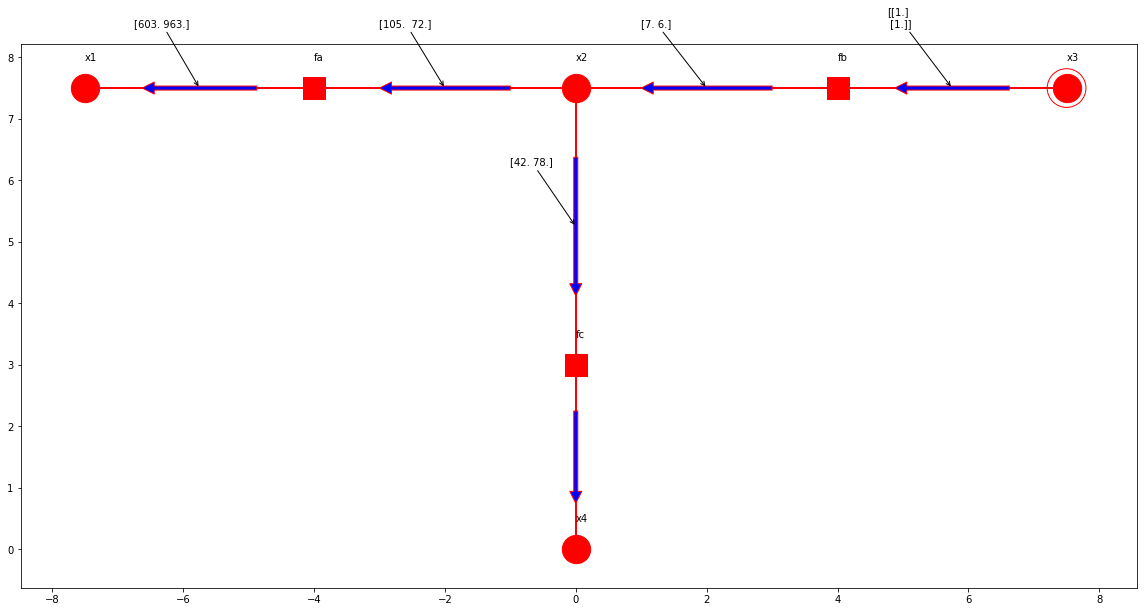

fc x4
[ 528. 1038.]



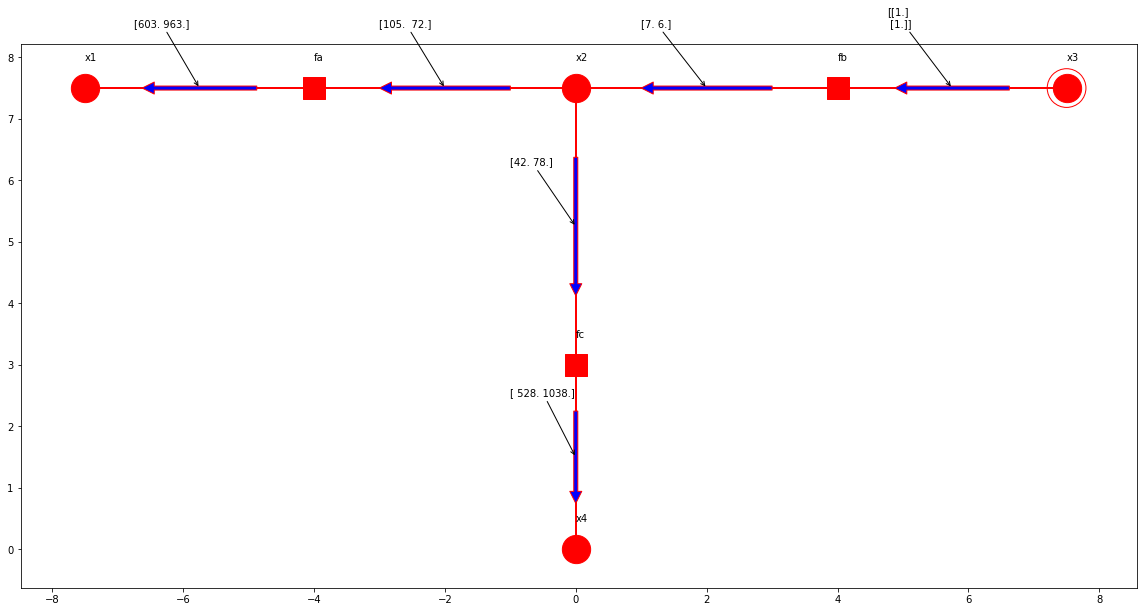

In [41]:
# lets run the belief_propagation algorithm from node x3 and see the intermediate results
belief_propagation(fg,query_node=x3,pos=pos)

In [49]:
# Print belief of variables
print("Belief of variable node x3:")
print(x3.belief())

print("Belief of variable node x2:")
print(x2.belief())

print("Belief of variable node x1:")
print(x1.belief())

print("Unnormalized belief of variable node x4:")
print(x4.belief(normalize=False))

print("Normalized belief of variable node X4:")
print(x4.belief(normalize=True))

Belief of variable node x3:
[0.67049808 0.32950192]
Belief of variable node x2:
[0.40229885 0.59770115]
Belief of variable node x1:
[0.38505747 0.61494253]
Unnormalized belief of variable node x4:
[ 528. 1038.]
Normalized belief of variable node X4:
[0.33716475 0.66283525]


Here's a simple animation created out of intermediate steps.

In [46]:
HTML("""
<video width="800" height="700" controls>
  <source src="sum_product.mp4" type="video/mp4">
</video>
""")

### The max-product algorithm

In [69]:
def max_product(graph, query_node=None, pos=None):
    """Max-product algorithm.
    Compute setting of variables with maximum probability on graphs
    that are tree structured.
    
    Parameters:
    graph:      instance of fglib graph ( a subclass of networkx graph) 
    query_node: the node chosen to run the algorithm
    pos:        a dictionary having key= (node in graph) and 
                value = (a tuple(x,y) :location in co-ordinate axes i.e, x and y)
    
    Return the setting of all query_nodes.
    """
    track = {}  # Setting of variables

    if query_node is None:  # pick random node
        query_node = choice(graph.get_vnodes())

    # Depth First Search to determine edges
    dfs = nx.dfs_edges(graph, query_node)

    # Convert tuple to reversed list
    backward_path = list(dfs)
    forward_path = reversed(backward_path)
    
    if pos == None:
        pos = nx.spring_layout(graph,scale=10)

    # Messages in forward phase
    messages = []
    print('forward')
    for (v, u) in forward_path:  # Edge direction: u -> v
        msg = u.mpa(v)
        print(u,v)
        print(msg)
        print()
        messages.append((u,v,copy.deepcopy(msg)))
        graph[u][v]['object'].set_message(u, v, msg)
        drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, flow_direction=backward_path,messages=messages)

    print('backward tracking for the variable node values which contribute to max joint probability')
    # Messages in backward phase
    for (u, v) in backward_path:  # Edge direction: u -> v
        msg = u.mpa(v)
        graph[u][v]['object'].set_message(u, v, msg)

    #backward message
    messages = []
    # Maximum argument for query node
    track[query_node] = query_node.argmax()
    messages.append((query_node,track[query_node]))
    drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, flow_direction=backward_path,backward=True,messages_node=messages)

    # Back-tracking
    for (u, v) in backward_path:  # Edge direction: u -> v
        if v.type == nodes.NodeType.factor_node:
            for k in v.record[u].keys():  # Iterate over outgoing edges
                print(v,k,v.record[u][k])
                messages.append((k,v.record[u][k]))
                track[k] = v.record[u][k]
                drawgraphWithMessage(graph,pos=pos,chosen_node=query_node,flow_direction=backward_path,backward=True,messages_node=messages)

    # Return maximum probability for query node and setting of variable
    return query_node.maximum(), track



forward
x4 fc
[[1.]
 [1.]]



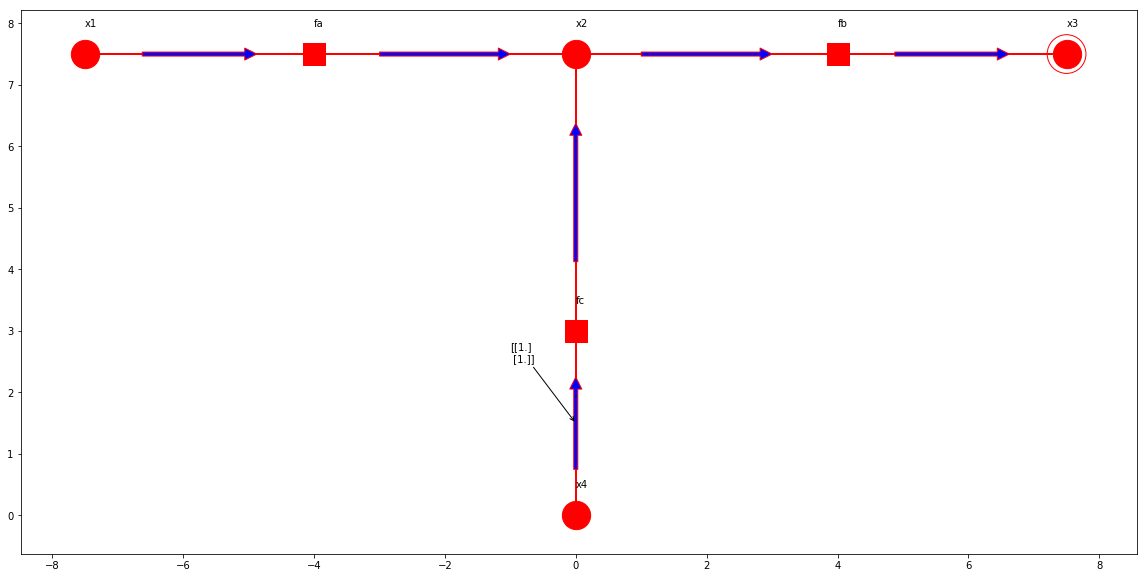

fc x2
[8. 9.]



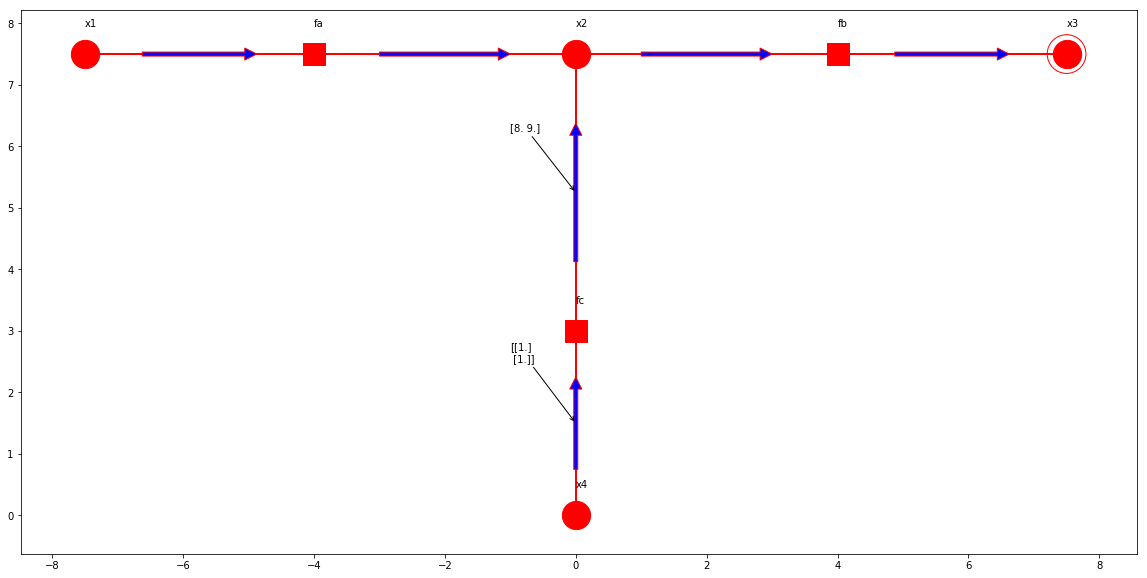

x1 fa
[[1. 1.]]



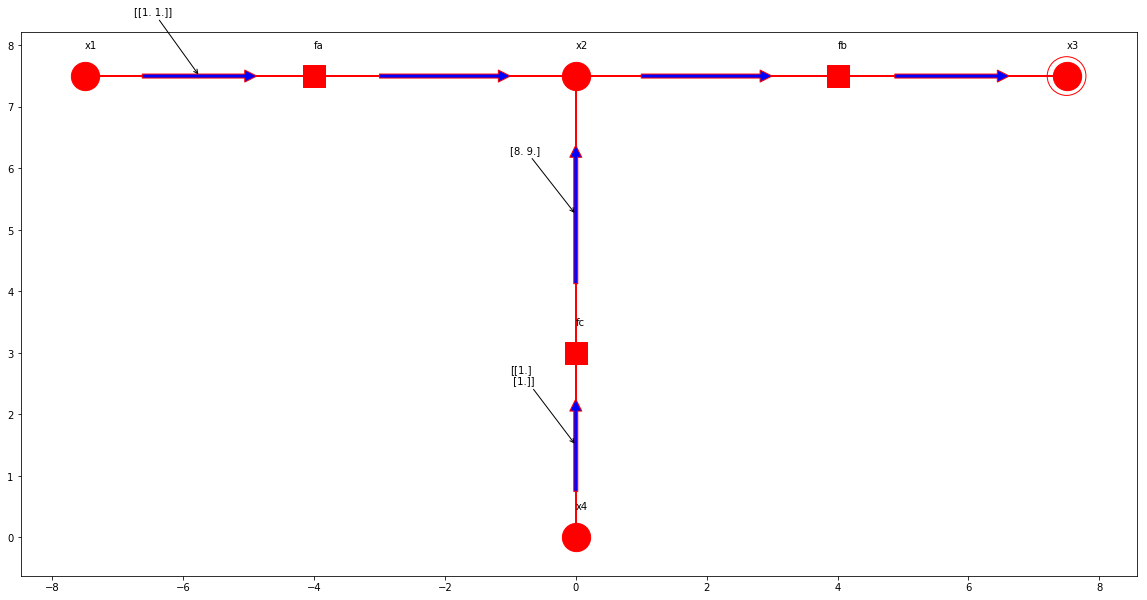

fa x2
[3. 9.]



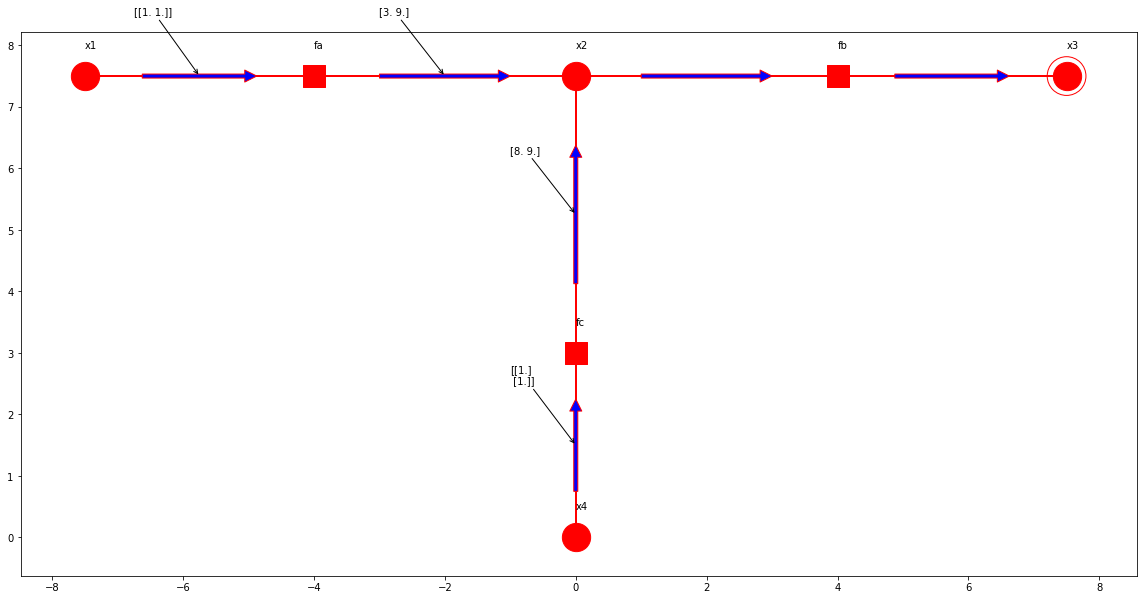

x2 fb
[24. 81.]



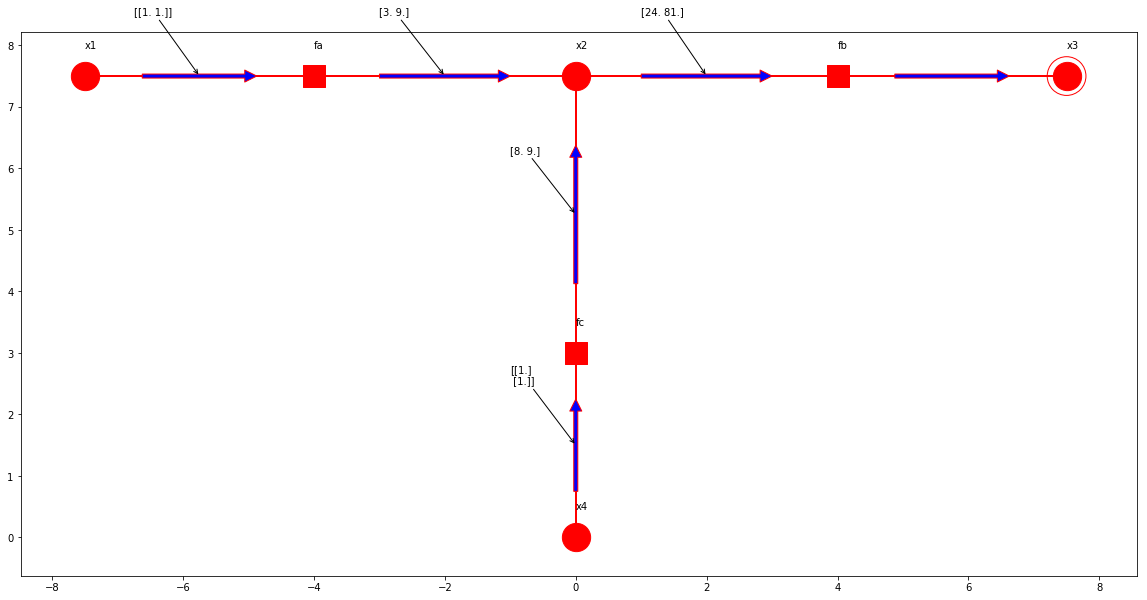

fb x3
[405.  96.]



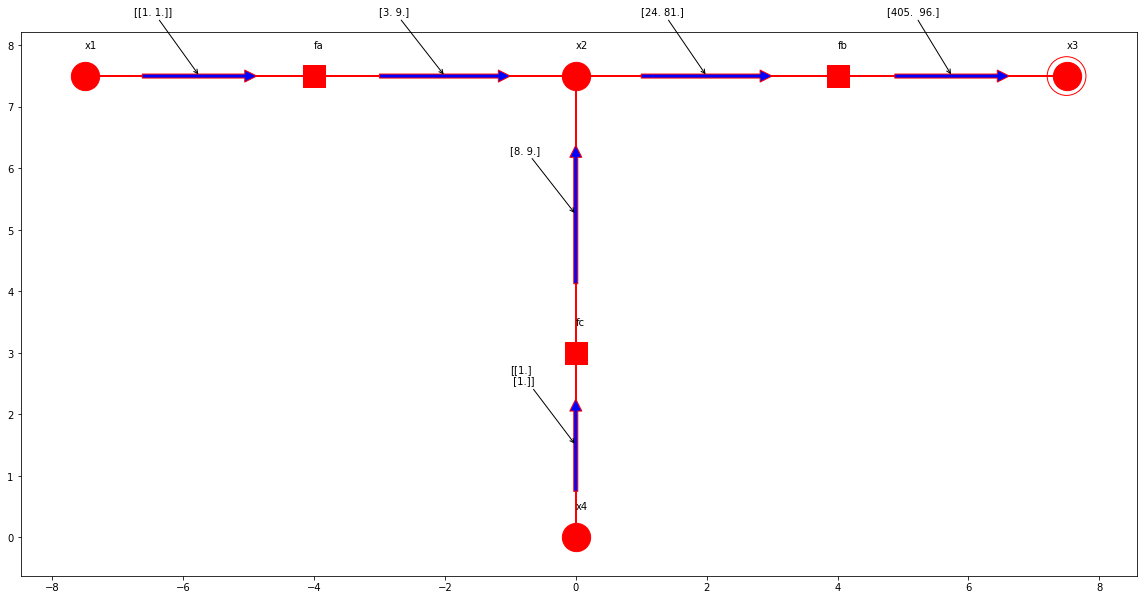

backward tracking for the variable node values


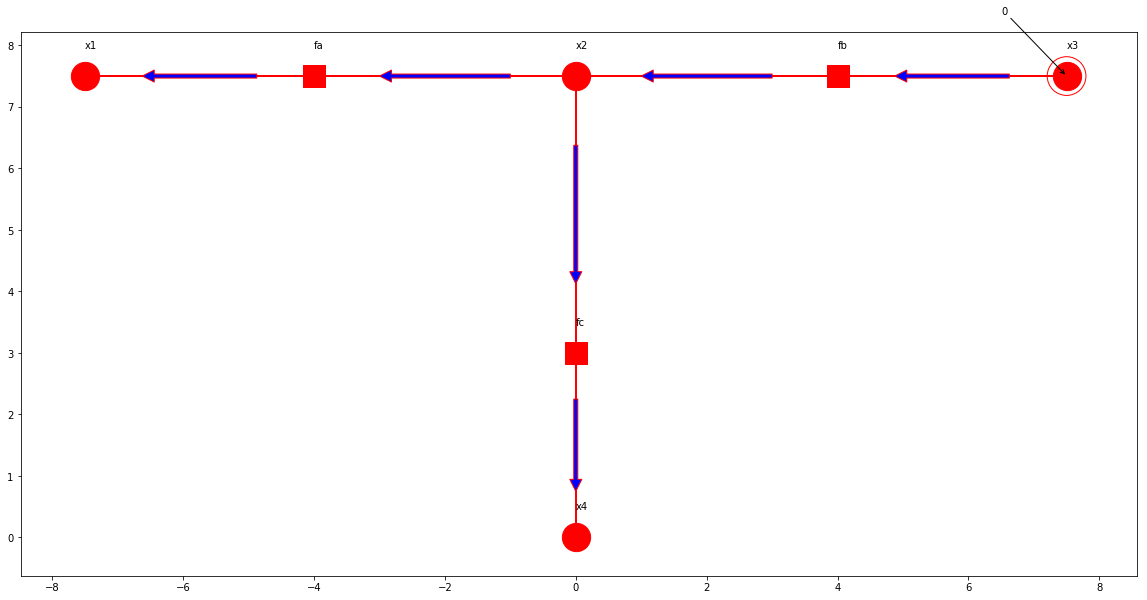

fb x2 0


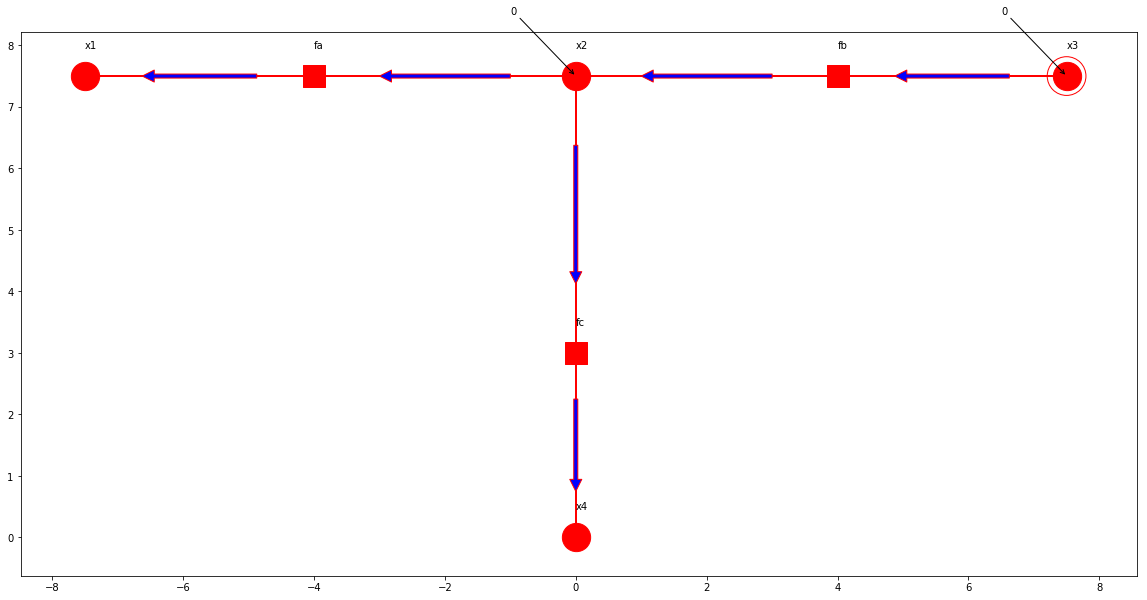

fa x1 1


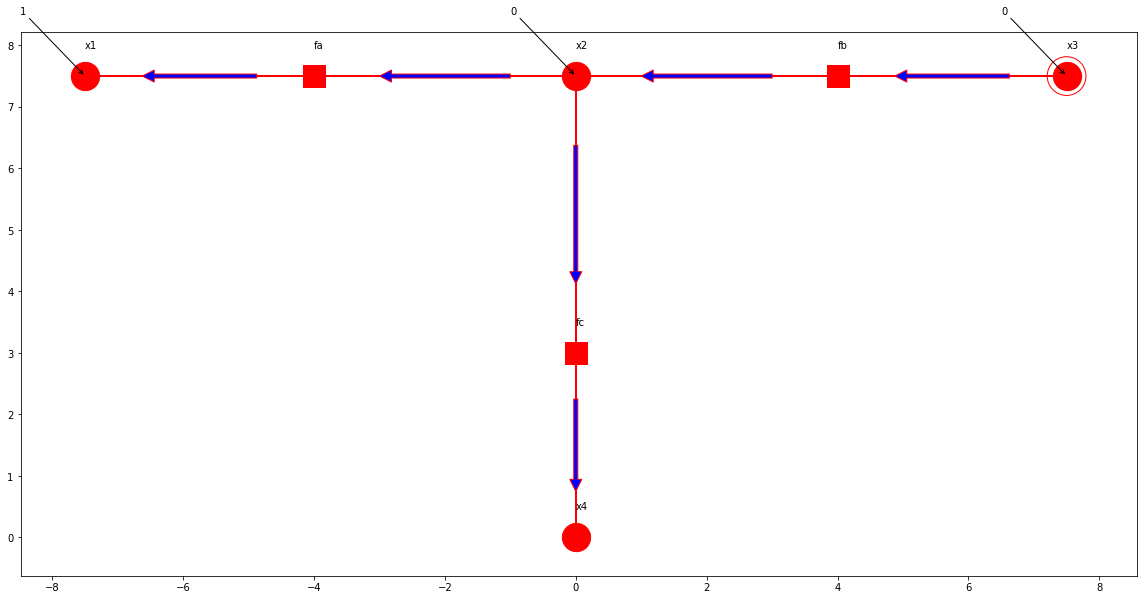

fc x4 0


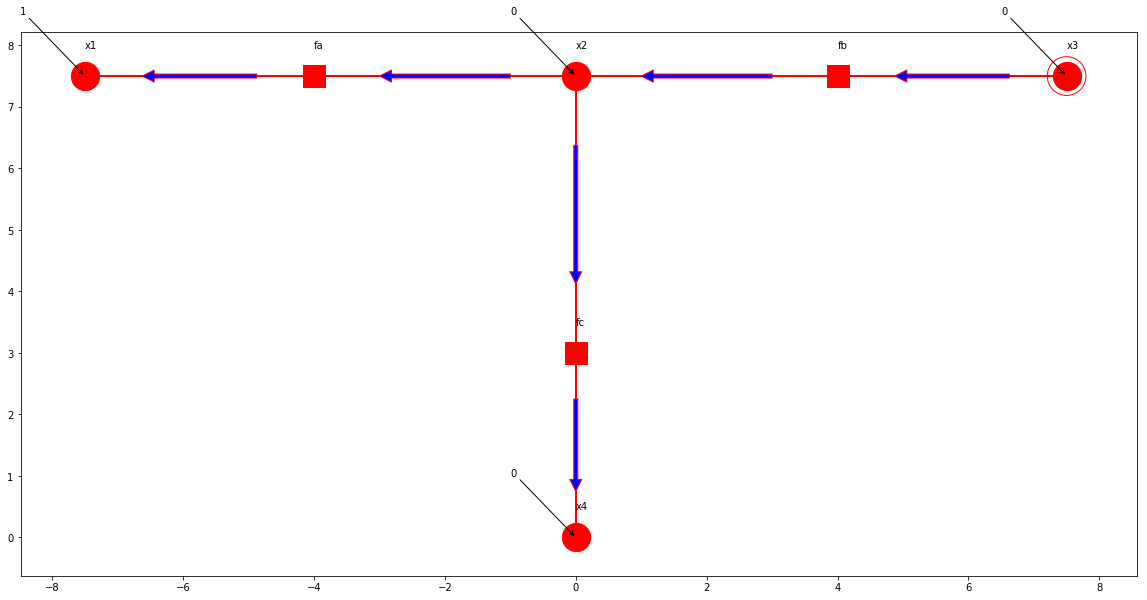

In [72]:
max_joint_prob,track = max_product(fg,query_node=x3,pos=pos)

In [73]:
print('the highest obtained joint probability is',max_joint_prob)
print('obtained from the following discrete values of the variables')
for v in track:
    print(v,'->',track[v])

the highest obtained joint probability is 0.8083832335329342
obtained from the following discrete values of the variables
x3 -> 0
x2 -> 0
x1 -> 1
x4 -> 0


Here's a simple animation created out of intermediate steps.

In [76]:
HTML("""
<video width="800" height="700" controls>
  <source src="max_product.mp4" type="video/mp4">
</video>
""")

### The max-sum algorithm

In [74]:
def max_sum(graph, query_node=None, pos=None):
    """Max-sum algorithm.
    Compute setting of variable for maximum probability on graphs
    that are tree structured.
    
    Parameters:
    graph:      instance of fglib graph ( a subclass of networkx graph) 
    query_node: the node chosen to run the algorithm
    pos:        a dictionary having key= (node in graph) and 
                value = (a tuple(x,y) :location in co-ordinate axes i.e, x and y)
    
    Return the setting of all query_nodes.
    """
    track = {}  # Setting of variables
    
    if pos == None:
        pos = nx.spring_layout(graph,scale=10)

    if query_node is None:  # pick random node
        query_node = choice(graph.get_vnodes())

    # Depth First Search to determine edges
    dfs = nx.dfs_edges(graph, query_node)

    # Convert tuple to reversed list
    backward_path = list(dfs)
    forward_path = reversed(backward_path)

    messages = []
    print('forward')
    
    # Messages in forward phase
    for (v, u) in forward_path:  # Edge direction: u -> v
        msg = u.msa(v)
        print(u,v)
        print(msg)
        print()
        messages.append((u,v,copy.deepcopy(msg)))
        graph[u][v]['object'].set_message(u, v, msg)
        drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, flow_direction=backward_path,messages=messages)

    print('backward tracking for the variable node values which contribute to max joint probability')
    # Messages in backward phase
    for (u, v) in backward_path:  # Edge direction: u -> v
        msg = u.msa(v)
        graph[u][v]['object'].set_message(u, v, msg, logarithmic=True)

    #backward message
    messages = []
    # Maximum argument for query node
    track[query_node] = query_node.argmax()

    messages.append((query_node,track[query_node]))
    drawgraphWithMessage(graph,pos=pos,chosen_node=query_node, flow_direction=backward_path,backward=True,messages_node=messages)

    # Back-tracking
    for (u, v) in backward_path:  # Edge direction: u -> v
        if v.type == nodes.NodeType.factor_node:
            for k in v.record[u].keys():  # Iterate over outgoing edges
                print(v,k,v.record[u][k])
                messages.append((k,v.record[u][k]))
                track[k] = v.record[u][k]
                drawgraphWithMessage(graph,pos=pos,chosen_node=query_node,flow_direction=backward_path,backward=True,messages_node=messages)



    # Return maximum probability for query node and setting of variable
    return query_node.maximum(), track

forward
x4 fc
[[0.]
 [0.]]



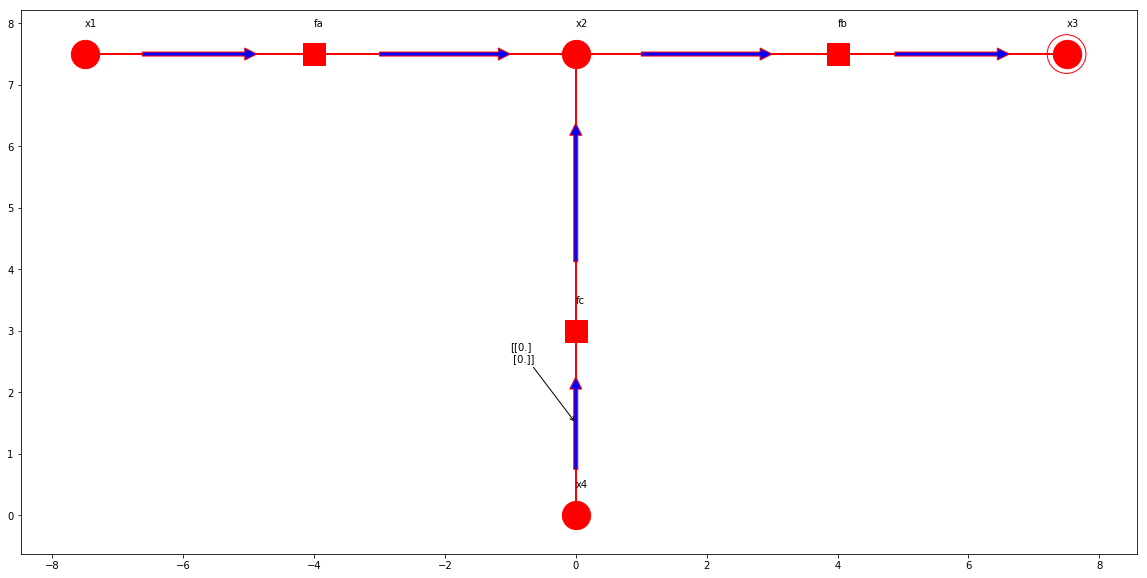

fc x2
[2.07944154 2.19722458]



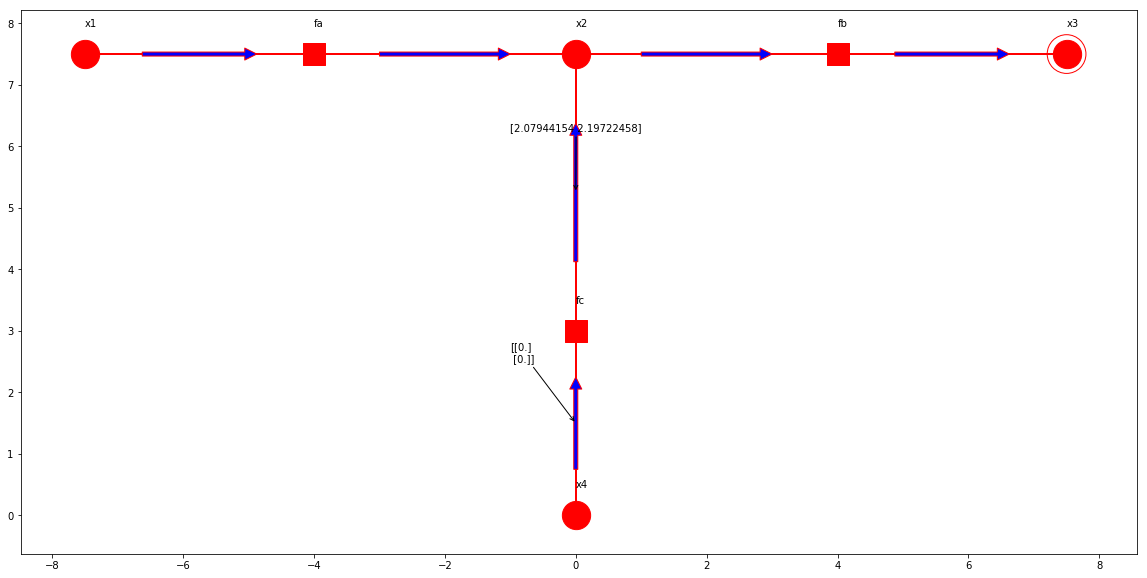

x1 fa
[[0. 0.]]



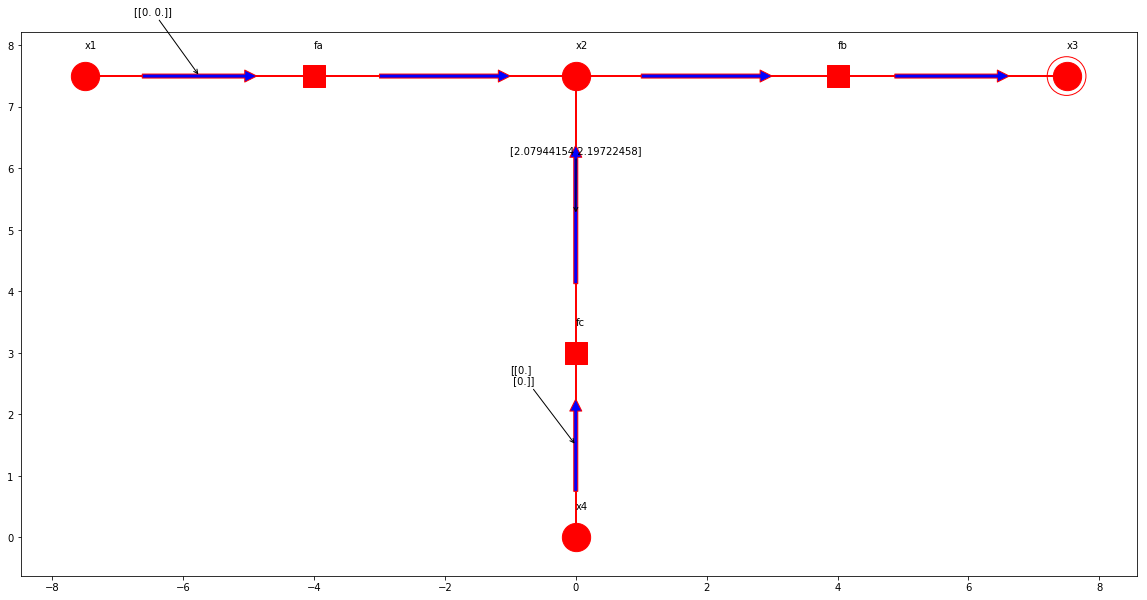

fa x2
[1.09861229 2.19722458]



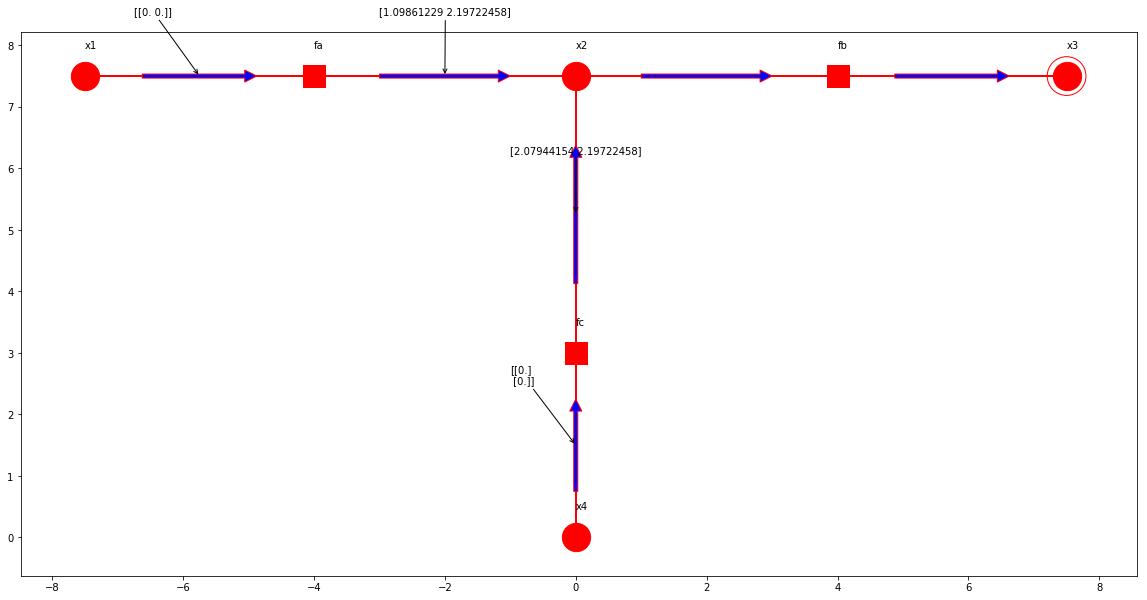

x2 fb
[3.17805383 4.39444915]



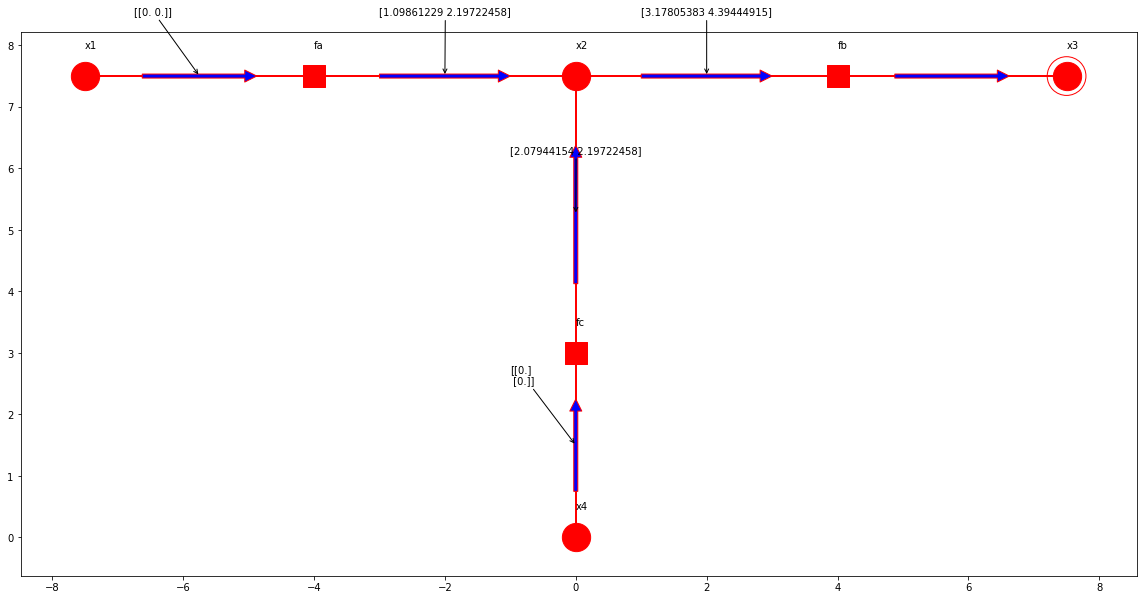

fb x3
[6.00388707 4.56434819]



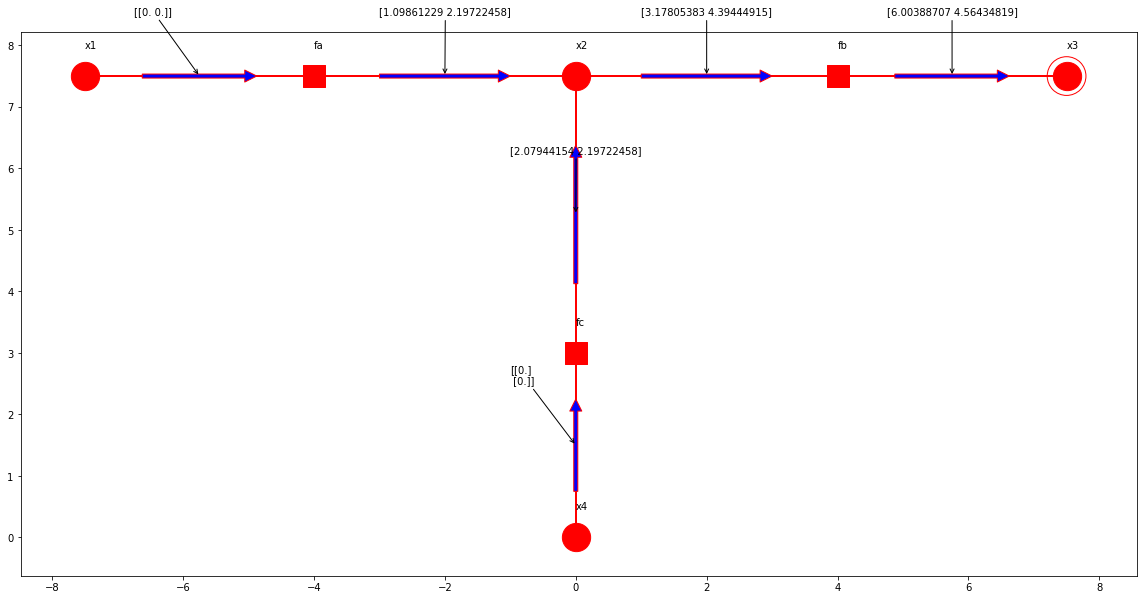

backward tracking for the variable node values which contribute to max joint probability


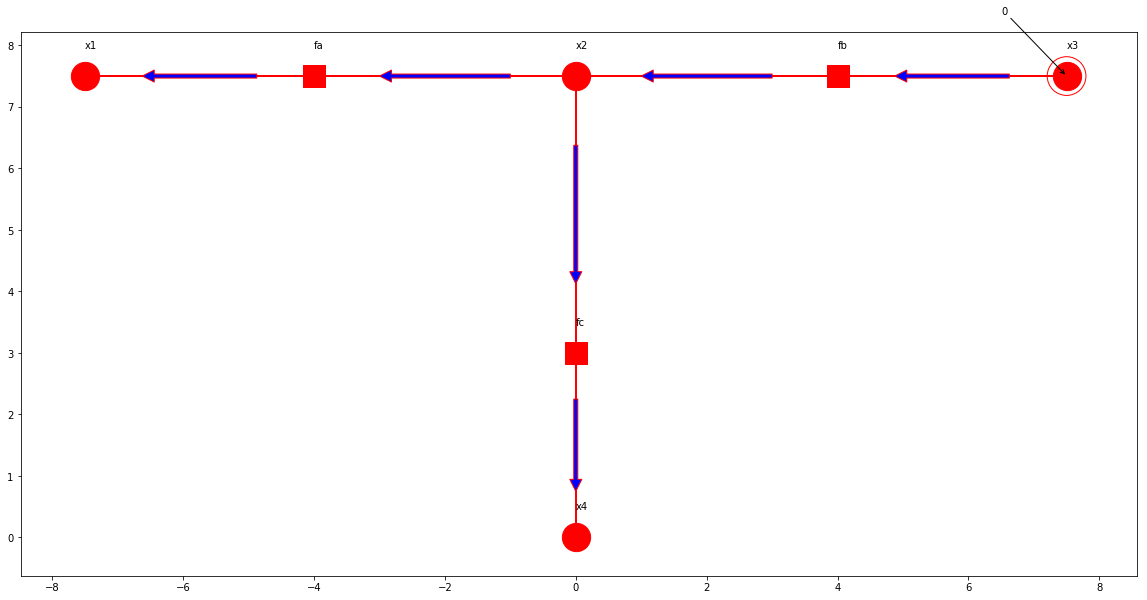

fb x2 0


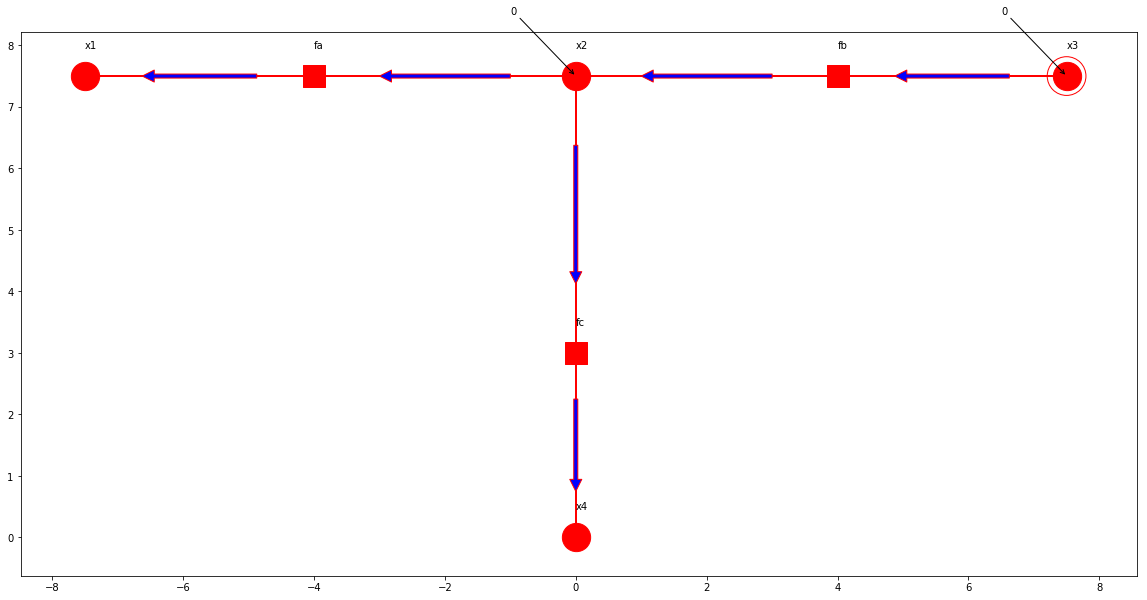

fa x1 1


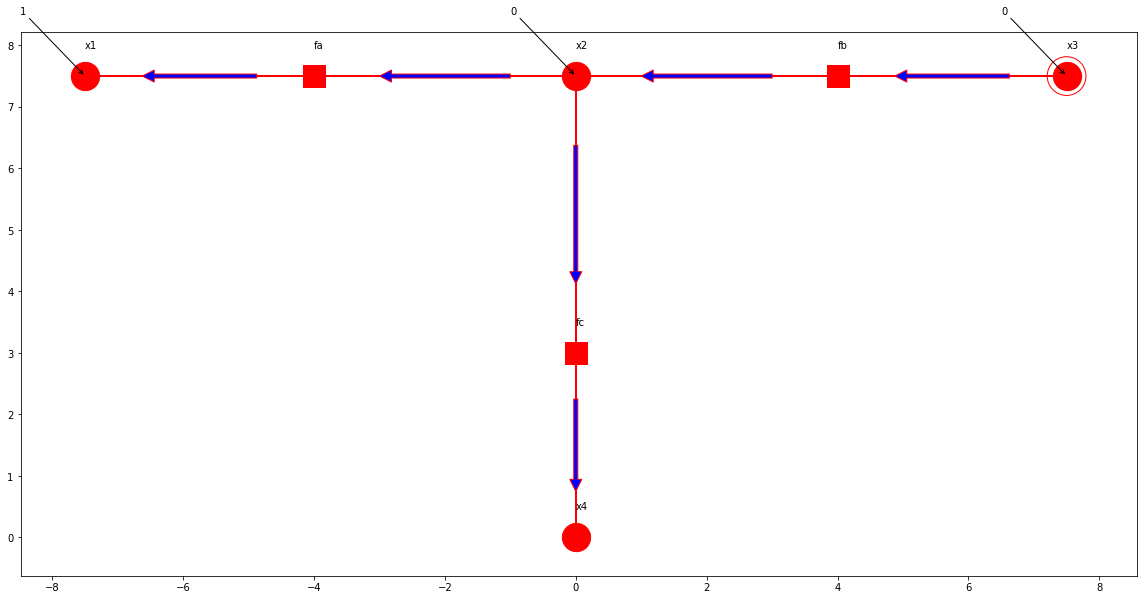

fc x4 0


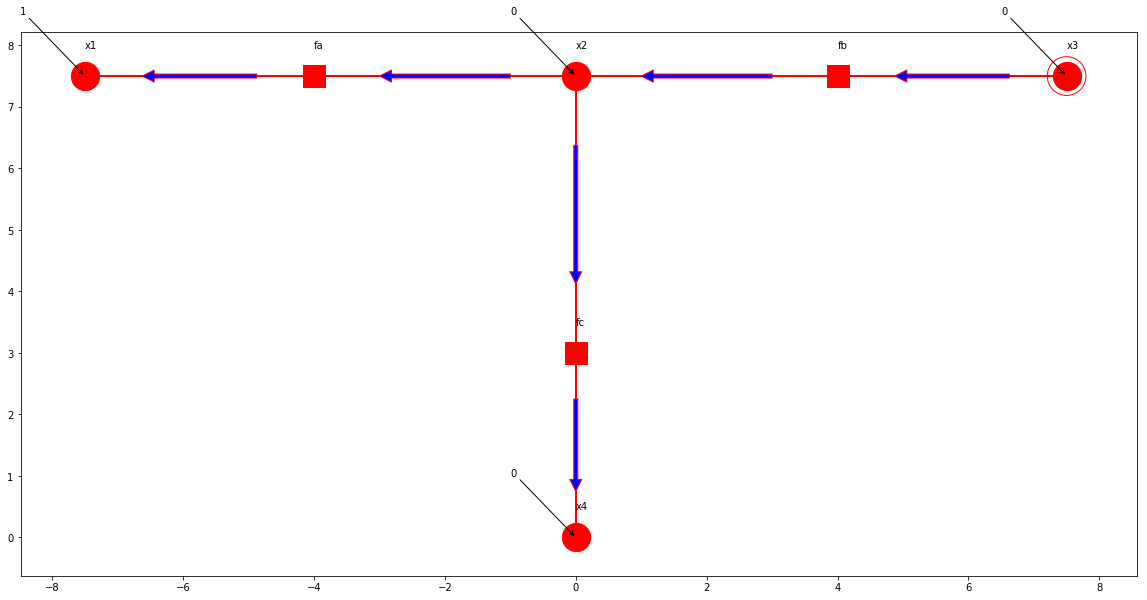

In [75]:
max_joint_prob,track = max_sum(fg,query_node=x3,pos=pos)

In [79]:
print('the highest obtained joint probability is',max_joint_prob)
print('obtained from the following discrete values of the variables')
for v in track:
    print(v,'->',track[v])

the highest obtained joint probability is 0.568106871223876
obtained from the following discrete values of the variables
x3 -> 0
x2 -> 0
x1 -> 1
x4 -> 0


Here's a simple animation created out of intermediate steps.

In [78]:
HTML("""
<video width="800" height="700" controls>
  <source src="max_sum.mp4" type="video/mp4">
</video>
""")

### ToDo
Create a graph instance of fglib with variables, factors and nodes for the graph image shown below.
Try to run inference algorithms on that graph.
<img src="to_do_graph.png" />
The joint distribution for the graph is given as:
<img src="to_do_graph_joint_distribution.png" />

### References
1. Chatterjee, S. Denoising Images and Markov Random Fields
[http://souravc83.github.io/denoising-images-and-markov-random-fields.html]
2. Bishop, M. Pattern Recognition and Machine Learning, Ch:8
[http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf]
3. fglib [https://github.com/danbar/fglib]
4. Networkx [http://networkx.github.io/]
5. MNIST dataset from kaggle.[https://www.kaggle.com/scolianni/mnistasjpg/version/1]
